In [1]:
from crosscorrelate import test_against_real_data
import numpy as np
import random
import time
import csv
import os
import math
import statistics
from multiprocessing import Pool

In [2]:
def create_new_set(setlength):
    new_set = []
    for i in range(setlength):
        new_set.append(round(random.random(),4))
    count = 0
    for k in new_set:
        i = round(k, 4)
        new_set[count] = i
        count += 1

        return new_set

In [3]:
from PyTCI.weights import leanbodymass
from PyTCI.models import propofol
from patient_solver import solve_for_patient

class New_model(propofol.Propofol):
    def __init__(self, age, weight, height, sex, params):
        
        lean_body_mass = leanbodymass.hume66(height, weight, sex)
        
        self.v1 = ((params[1] * 50) - params[2]*(age - (params[3] * 100))) * (params[4] * (lean_body_mass - (params[5] * 100)))
        self.v2 = params[6] * lean_body_mass * 2
        self.v3 = params[7] * weight * 5
        
        self.Q1 = ((params[8] * self.v1) * (params[9] * age)) ** 0.75
        self.Q2 = (params[9] * self.v2)** 0.75
        self.Q3 = (params[0] * self.v3) ** 0.75
        
        self.keo = 0
        
        propofol.Propofol.from_clearances(self)
        propofol.Propofol.setup(self)
        
class SIVA_model(propofol.Propofol):
    def __init__(self, age, weight, height, sex, params):
        
        lean_body_mass = leanbodymass.hume71(height, weight, sex)
        
        self.v1 = (params[0] * lean_body_mass) * (age **(-params[1]))
        self.v2 = params[2] * lean_body_mass * 2
        self.v3 = params[3] * weight * 5
        
        self.Q1 = (params[4] * (weight ** 0.75) ) * (age ** (-params[5]))
        self.Q2 = params[6] * (self.v2 ** 0.75)
        self.Q3 = params[7] * (self.v3 ** 0.75)
        
        self.keo = 0
        
        propofol.Propofol.from_clearances(self)
        propofol.Propofol.setup(self)        
                                                         
                   
                   
                   
def solve_for_custom(patient, params):
    patient_model = SIVA_model(patient["age"], patient["weight"], patient["height"], patient["sex"], params )
    return solve_for_patient(patient_model, patient["events"])

In [4]:
def create_new_population(size, setlength):
    pop_size = size
    pop_list = []
    for i in range(pop_size):
        newparam = create_new_set(setlength)
        pop_list.append(newparam)
    return pop_list

In [5]:
def mutate_population(children, fittest, second, mutants):
    pop_list = []
    
    #keep fittest set in so we don't go backwards
    pop_list.append(fittest)
    def mutate_chromosome(chrome):
        b = random.random()
        c = len(fittest)
        c = 1 / c
        if b < (c/2):
            chrome = chrome * np.random.normal(1, 0.3)
        elif b < c:
            chrome = chrome * np.random.normal(1, 0.1)
        else:
            chrome = chrome * 1
        return round(chrome, 6)

    # breed parents to create children
    def breed(sprogs, p1, p2):
        for i in range(sprogs):
            child = []
            count = 0
            for k in p1:
                a = random.random()
                if a < 0.5:
                    k = p2[count]
                    k = mutate_chromosome(k)
                    child.append(k)
                else:
                    k = mutate_chromosome(k)
                    child.append(k)

                count += 1
            pop_list.append(child)

    breed(children, fittest, second)

    # immigration to escape local minima
    rand1 = create_new_set(len(fittest))
    rand2 = create_new_set(len(fittest))

    pop_list.append(rand1)
    pop_list.append(rand2)

    breed(2, fittest, rand1)
    breed(2, fittest, rand2)

    # create mutants of fittest
    for i in range(mutants):
        mutant = []
        for k in fittest:
            b = random.random()
            if b < 0.2:
                mut_factor = 0.3
            else:
                mut_factor = 0.1
            k = k * np.random.normal(1, mut_factor)
            k = round(k, 4)
            mutant.append(k)
        pop_list.append(mutant)

    return pop_list

In [6]:
def test_against_real_data(stuff):
    pmin = stuff[0]
    pmax = stuff[1]
    params = stuff[2]
    patients = stuff[3]

    medians = []
    bias = []

    for patient in patients[pmin:pmax]:
        res = solve_for_custom(patient, params)
        medians.append(res["median"])
        bias.append(res["bias"])

    data = (medians, bias)
    return data

In [7]:
from csvreader import read_patient_csv
patients = read_patient_csv()

In [8]:
patients = patients[:577]

adults = []

for patient in patients:
    if patient["age"] > 17.9:
        adults.append(patient)
        
patients = adults

In [9]:
model_parameters = [0.1455, 0.094332, 0.0643, 0.626, 0.0609, 0.7895, 0.6413, 0.0181, 0.2004]

stuff = [1, 250, model_parameters, patients]

MDAPE, MDPE = test_against_real_data(stuff)

In [10]:
def multi_core_test(cores, maxpt, params):
    # TODO change this so params can be any size

    step_size = round(maxpt / cores)

    jobs = []

    for idx in range(cores):
        a = step_size * idx + 1
        b = step_size * (idx + 1)
        if idx == (cores-1):
            b = maxpt
        thing = (a, b, params, patients)
        jobs.append(thing)

    
    results = pool.map(test_against_real_data, jobs)
    
    MDAPEs = []
    MDPEs =  []
    
    for i in results:
        MDAPEs += i[0]
        MDPEs += i[1]

    MDAPE = statistics.median(MDAPEs)
    MDPE = statistics.median(MDPEs)
    
    hypot = math.hypot(MDAPE, MDPE)

    # "%-15s %-15s" % (rms, meds)
    data = (hypot, MDAPE, MDPE)

    # return meds
    return data

In [11]:
import time
from IPython import display
from multiprocessing import Pool
import matplotlib.pyplot as plt


print("creating population")
pop = create_new_population(10, 8)
pool = Pool(10)


def test_population(pop):

    pop_list = []
    for i in pop:
        try:
            result = multi_core_test(10, 418, i)
            fitness = result[0]
            pop_list.append([fitness, i, result])

        except:
            result = (99, 99, 99)
            fitness = result[0]
            pop_list.append([fitness, i, result])
    
    pop_list.sort()
    output = (pop_list[0][1], pop_list[0][2], pop_list[1][1], pop_list[1][2])

    return output

print("beginning test")
fit_results = test_population(pop)

fittest_set = fit_results[0]
best_fitness = fit_results[1][1]
second_set = fit_results[2]
second_fitness = fit_results[3][1]

max_tries = 0
while best_fitness > 9.9:
    fit_results = test_population(pop)
    best_fitness = fit_results[1][1]
    
    print ("trying again")    

pltB = []
pltS = []


print("starting")
# 
for i in range(30):
    
   
    new_pop = mutate_population(10, fittest_set, second_set, 10)
    fit_results = test_population(new_pop) 
    
    if fit_results[1][0] < 99:
        fittest_set = fit_results[0]
        best_fitness = fit_results[1][0]
        second_set = fit_results[2]
        second_fitness = fit_results[3][0]

        print(i, fit_results[1])
        
        pltB.append(fit_results[1][1])
        pltS.append(fit_results[1][2])

print(fittest_set)
print ("finished!!")

creating population
beginning test
starting
0 (0.5802331790735982, 0.5797014451137412, 0.024834988038939687)
1 (0.43931694810985067, 0.4383482776583288, -0.02915764686201445)
2 (0.3205692396599445, 0.3198318664676278, -0.02173049948778069)
3 (0.2991314992253836, 0.29848918614047637, 0.01959233487927741)
4 (0.29616539528481167, 0.2951657842116646, -0.024312572774631974)
5 (0.29616539528481167, 0.2951657842116646, -0.024312572774631974)
6 (0.29062635308026363, 0.28981257178222364, -0.02173362237887491)
7 (0.28830335113368166, 0.2876694823053644, -0.019107360494704566)
8 (0.28782017628840995, 0.28742220474236224, -0.015130436204253216)
9 (0.28782017628840995, 0.28742220474236224, -0.015130436204253216)
10 (0.2878107818267809, 0.2874127981554675, -0.015130419431971152)
11 (0.2878107818267809, 0.2874127981554675, -0.015130419431971152)
12 (0.2878107818267809, 0.2874127981554675, -0.015130419431971152)
13 (0.28744905693198897, 0.2870498835138592, -0.015143470730638209)
14 (0.2874482868198447

In [12]:
from patient_solver import solve_for_schnider, solve_for_marsh, solve_for_eleveld


def test_with_schnider (stuff):
    pmin = stuff[0]
    pmax = stuff[1]
    params = stuff[2]
    patients = stuff[3]

    medians = []
    bias = []

    for patient in patients[pmin:pmax]:
        res = solve_for_schnider(patient, params)
        medians.append(res["median"])
        bias.append(res["bias"])

    data = (medians, bias)
    return data

def test_with_eleveld (stuff):
    pmin = stuff[0]
    pmax = stuff[1]
    params = stuff[2]
    patients = stuff[3]

    medians = []
    bias = []

    for patient in patients[pmin:pmax]:
        res = solve_for_eleveld(patient, params)
        medians.append(res["median"])
        bias.append(res["bias"])

    data = (medians, bias)
    return data

params = []
stuff = [1, 418, params, patients]

mdpe, bias = test_with_schnider(stuff)


Smdpe = statistics.median(mdpe)
Sbias = statistics.median(bias)

mdpe, bias = test_with_eleveld(stuff)

Emdpe = statistics.median(mdpe)
Ebias = statistics.median(bias)

<IPython.core.display.Javascript object>


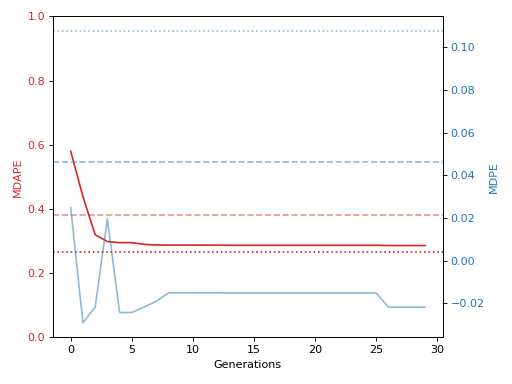

In [13]:
%matplotlib notebook

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Generations')
ax1.set_ylabel('MDAPE', color=color)
ax1.set_ylim(ymin=0)
ax1.plot(pltB,  color=color)
ax1.axhline(y=Smdpe,color=color, linestyle='--', alpha=0.5)
ax1.axhline(y=Emdpe,color=color, linestyle=':', alpha=1)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('MDPE', color=color)  # we already handled the x-label with ax1
ax2.plot(pltS, color=color, alpha=0.5)
ax2.axhline(y=Sbias, color=color, linestyle='--', alpha=0.5)
ax2.axhline(y=Ebias, color=color, linestyle=':', alpha=0.5)
#ax2.set_ylim(ymin=0)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

<IPython.core.display.Javascript object>


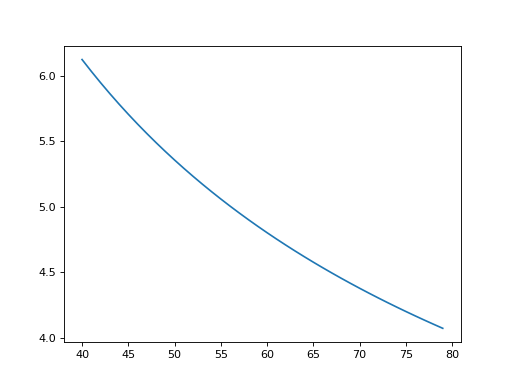

In [14]:
x = []
y = range(40,80)
for i in range(40, 80):
    x.append((70 * 0.8)*(i**(-0.6)))
    
fig4 = plt.figure()
plt.plot(y, x)
plt.show()